# Combining ARIMA with Decomposition

We've already gone through the process of a simple ARIMA model. In this exercise we're going to build on that slightly by using a combination of an ARIMA model with the `seasonal decompose` tool you saw in the lecture. There are models we can use __specifically__ for dealing with seasonality, but we're going to go step by step here and manually pull apart this time series so we fully understand it and some of the issues we can have when working with TS data.

For this challenge we're going to be working with the daily CO2 ppm measurements, specifically, the daily CO2 measurements from the Mauna Loa Observatory 🌋

They have been taken since since 1958, and are a cornerstone of climate science. Perched at over 3,000 meters in Hawaii, the observatory is well-positioned to monitor global atmospheric carbon levels, largely free from local emissions. While the record is robust, __it does contain gaps due to occasional instrument issues or extreme weather__, which researchers must account for in their analyses to maintain the integrity of this critical dataset.  We'll be using a portion of data that has been taken __almost__ daily since 1974 - we will address the gaps in the data throughout the course of the notebook!

If you're curious about the climate work done by the lab, you can read more about it here: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Loading and exploring the data

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/co2_daily_mlo.csv")

In [3]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


We can see the data isn't formatted very nicely for us to work with, so let's solve that step first by using `pd.to_datetime()` (you can use the function on multiple columns at once 👀). Check the [docs](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to find out more.

Once you've formatted it correctly, set it as your index.

In [87]:
df['date'] = pd.to_datetime(df[['year','month','day']])
df=df.set_index('date')
df = df.sort_index()
df

,year,month,day,CO2 molfrac (ppm)
date,,,,
1974-05-17,1974.0,5.0,17.0,333.38
1974-05-18,1974.0,5.0,18.0,333.11
1974-05-19,1974.0,5.0,19.0,333.46
1974-05-20,1974.0,5.0,20.0,333.64
1974-05-21,1974.0,5.0,21.0,333.50
...,...,...,...,...
NaT,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN


Plot out your CO2 values and discuss with your partner what you see. Does it look like you have any gaps in your data? Are you __sure__? Check the top 50 values of your DataFrame

In [88]:
df.columns

Index(['year', 'month', 'day', 'CO2 molfrac (ppm)'], dtype='object')

<Axes: title={'center': 'daily CO2'}, xlabel='date', ylabel='ppm'>

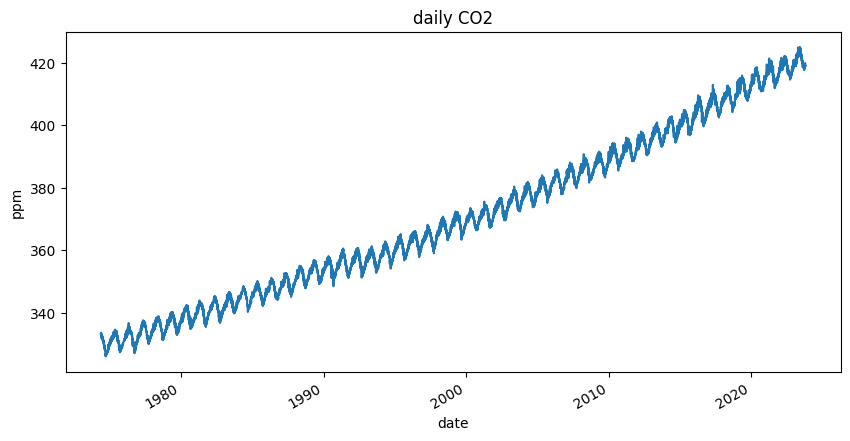

In [89]:
df['CO2 molfrac (ppm)'].plot(figsize=(10,5), title = 'daily CO2', ylabel='ppm')


In [90]:
df.isna().sum()

year                 2862
month                2862
day                  2862
CO2 molfrac (ppm)    2862
dtype: int64

In [28]:
(df.index.max() - df.index.min()).days, len(df)


(18057, 15196)

In [91]:
missing = (df.index.max() - df.index.min()).days - len(df)


We're missing some dates 😱 Even though we don't have any obvious `NaN` values, there are missing dates from our index. This is something you need to be __really__ careful about with TS data.

Let's work out how many days we're missing. Subtracting your end date (the `max()` of your `index`) from your start date (the `min()` of your `index`)to see how many days __should__ between the two.

In [92]:
missing

-1

How does this differ from the number of days we __actually__ have in our DataFrame? Save your answer to a variable `missing`

In [93]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing FAILED                        [100%]

=================================== FAILURES ===================================
___________________________ TestMissing.test_missing ___________________________

self = <test_missing.TestMissing testMethod=test_missing>

    def test_missing(self):
>       self.assertEqual(self.result.missing, 2861)
E       AssertionError: -1 != 2861

test_missing.py:5: AssertionError
=========================== short test summary info ============================
FAILED test_missing.py::TestMissing::test_missing - AssertionError: -1 !=

Let's actually see where are missing values lie. Use `pd.date_range` to create the index we __should__ have. Then use the DataFrame's `.reindex()` function with this new date range to see where our null values actually are in our first 100 entries!

In [35]:
# Créer un index complet de dates journalières
full_index = pd.date_range(df.index.min(), df.index.max())

# Réindexer le DataFrame sur cette plage complète
df = df.reindex(full_index)

# Afficher les 100 premières lignes pour observer les NaN
df.head(100)


,year,month,day,CO2 molfrac (ppm)
1974-05-17,1974.0,5.0,17.0,333.38
1974-05-18,1974.0,5.0,18.0,333.11
1974-05-19,1974.0,5.0,19.0,333.46
1974-05-20,1974.0,5.0,20.0,333.64
1974-05-21,1974.0,5.0,21.0,333.50
...,...,...,...,...
1974-08-20,1974.0,8.0,20.0,329.07
1974-08-21,1974.0,8.0,21.0,329.41
1974-08-22,NaN,NaN,NaN,NaN
1974-08-23,1974.0,8.0,23.0,328.76


We simplest option here is to use the very useful `pd.interpolate("linear")` function to fill these in for us. Try running the cell below to see what it does:

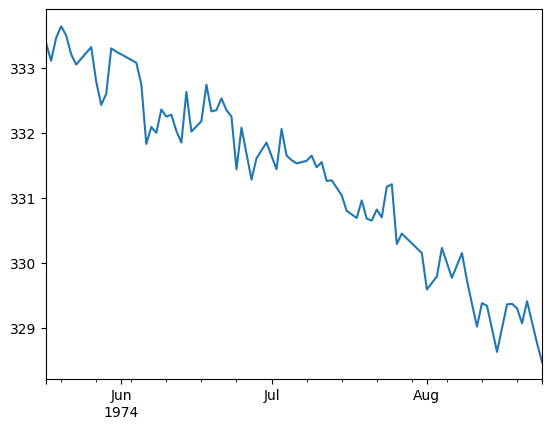

In [38]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot();

Interpolation uses a simple linear method to connect the dots for us 😊 Obviously this is making some assumptions that aren't perfectand we don't actually need to have daily samples - instead we'll `resample` our DataFrame on a monthly basis and try to model that. Try using the `.resample()` function to create a DataFrame with each month's average and name it `monthly`. See [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) here.

In [39]:
# On regroupe les données par mois et on prend la moyenne
monthly = df.resample('M').mean()

# Vérification rapide
monthly.head()


/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/1504098778.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').mean()


,year,month,day,CO2 molfrac (ppm)
1974-05-31,1974.0,5.0,23.923077,333.156923
1974-06-30,1974.0,6.0,16.160000,332.170400
1974-07-31,1974.0,7.0,15.416667,331.110000
1974-08-31,1974.0,8.0,16.615385,329.105769
1974-09-30,1974.0,9.0,16.454545,327.303182


If you __still__ have any remaining null values, you can use the `interpolate` to fill them in. Plot out your resampled data:

In [41]:
monthly.isna().sum()

year                 1
month                1
day                  1
CO2 molfrac (ppm)    1
dtype: int64

/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/4097864557.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M')["CO2 molfrac (ppm)"].mean().to_frame()


<Axes: >

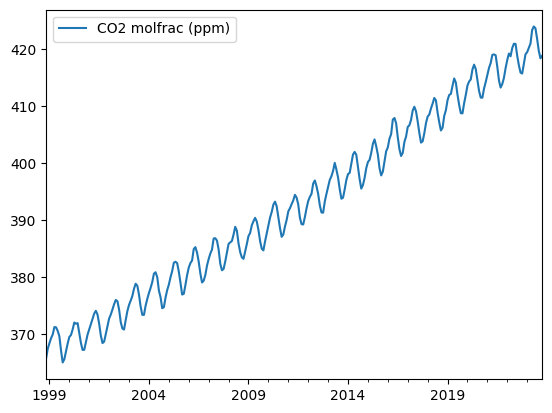

In [46]:
monthly = df.resample('M')["CO2 molfrac (ppm)"].mean().to_frame()

monthly[-300:].plot()

In [47]:
monthly["CO2 molfrac (ppm)"].iloc[0]

333.1569230769231

In [48]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

============================== 2 passed in 0.45s ===============================


💯 You can commit your code:

git add tests/monthly.pickle

git commit -m 'Completed monthly step'

git push origin master



## Train test split

Next up we need to split into a train and test set (we'll do an 80:20 split). Be cautious when doing this - we need our sets to be __continuous__!

In [49]:
# On fait un split temporel (pas aléatoire)
split = int(len(monthly) * 0.8)
train = monthly.iloc[:split]
test = monthly.iloc[split:]


Our data preparation is almost done. Before we start decomposing and modelling though, we should come up with a baseline to see how our model performs. 

The typical baselines we'd pick is just to guess the last available value to us. In our case, this is simply the final point in our `train` DataFrame.

In your `test` DataFrame, create a column called `naive_preds` and set it to be equal to our last available data point in `train`


In [50]:
# Dernière valeur connue du train
last_value = train["CO2 molfrac (ppm)"].iloc[-1]

# On prédit que tout le test = dernière valeur connue
test["naive_preds"] = last_value


/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/240988128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["naive_preds"] = last_value


Once you have this, calculate the mean absolute error between the two columns and set this as your `baseline_mae`.

In [51]:
from sklearn.metrics import mean_absolute_error

baseline_mae = mean_absolute_error(test["CO2 molfrac (ppm)"], test["naive_preds"])
baseline_mae


14.503777783267303

In [52]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

=============================== warnings summary ===============================
test_baseline.py::TestBaseline::test_first_value
  /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests/test_baseline.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

## Getting ready to model

With some Time Series models, we can simply throw our data at it and hope that it will decompose it, make it stationary for us and then model it for us (SARIMAX or TBATS are good examples of this), but we're going to go step by step instead. Since we're not relying on a model to remove seasonality and trend for us, we will take care of them ourselves.

Import the `seasonal_decompose` tool that you saw in the lecture and try both methods on your Time Series (both "multiplicative" and "additive"). 

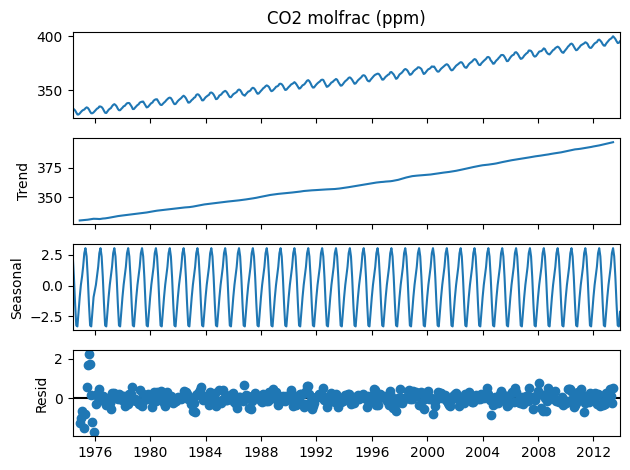

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Supprimer les NaN 
train_clean = train["CO2 molfrac (ppm)"].dropna()

# Additive decomposition
decomp_add = seasonal_decompose(train_clean, model='additive', period=12)
decomp_add.plot()
plt.show()




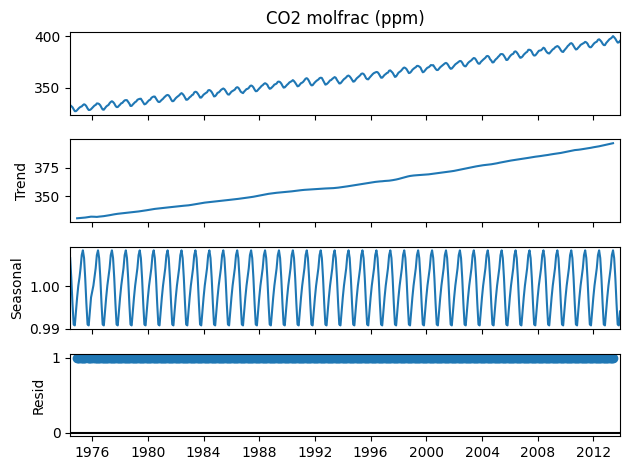

In [58]:
# Multiplicative decomposition
decomp_mul = seasonal_decompose(train_clean, model='multiplicative', period=12)
decomp_mul.plot()
plt.show()

In [ ]:
# YOUR CODE HERE

Plot the residuals (access the `.resid` attribute) from both and remember - we want the one that looks as __non-influenced__ by time as possible

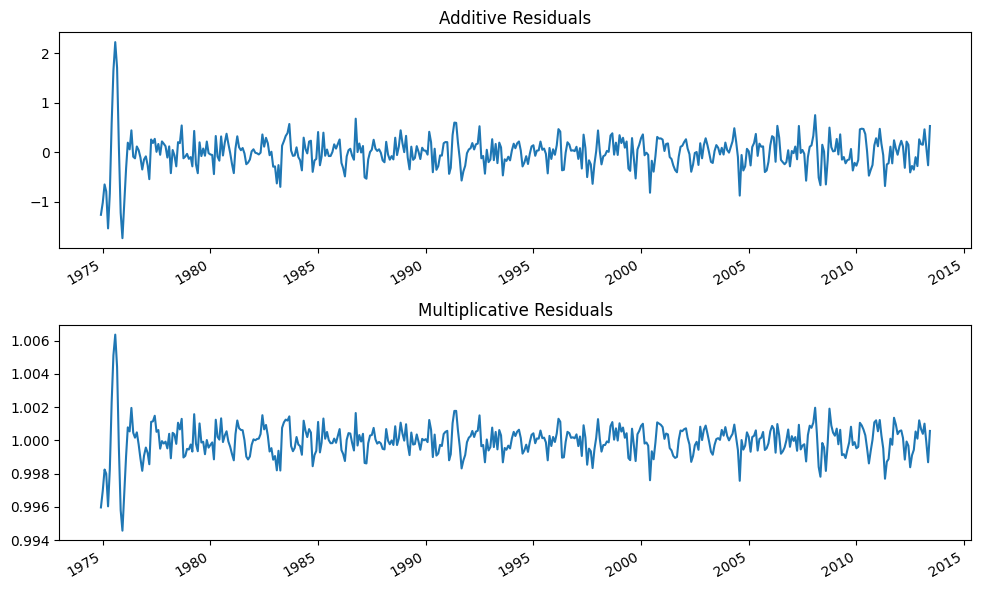

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

decomp_add.resid.plot(ax=ax[0], title="Additive Residuals")
decomp_mul.resid.plot(ax=ax[1], title="Multiplicative Residuals")

plt.tight_layout()
plt.show()


In [ ]:
# YOUR CODE HERE

Since both look reasonably stationary, we'll pick the multiplicative model.

Our strategy now is to take out the seasonal component of our time series. 

How can we do this? 🤔


First, create a column called `"seasonal_component"`in your `train` DataFrame that is filled with the `.seasonal` component of your time series. 

After you do this, create a separate, smaller DataFrame that only includes __one year__ of seasonal components (ie. the first 12 rows of your `seasonal components` column). This will be useful for us later on. Name it `seasonal_one_year` and make sure you have a `"month"` column equal to the corresponding `index.month` (e.g. you have have a row with the January seasonal component and a 1 next to it). 

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [60]:
# On garde la décomposition multiplicative
train["seasonal_component"] = decomp_mul.seasonal

# Créer un DataFrame contenant une seule année de saisonnalité
seasonal_one_year = train[["seasonal_component"]].head(12).copy()
seasonal_one_year["month"] = seasonal_one_year.index.month

seasonal_one_year.head()


/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/820821408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["seasonal_component"] = decomp_mul.seasonal


,seasonal_component,month
1974-05-31,1.006625,5
1974-06-30,1.001937,6
1974-07-31,0.995938,7
1974-08-31,0.991020,8
1974-09-30,0.990798,9


Since this is from a multiplicative model, if we want to __remove__ this seasonal component, we'll need to __divide__ our original time series by these repeating (12-month cycle) values.

In [61]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.50s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



Create a new column named `"seasonal_stripped"` equal to the value of your original time series divided by the seasonal component.

In [62]:
# Retirer la saisonnalité (modèle multiplicatif)
train["seasonal_stripped"] = train["CO2 molfrac (ppm)"] / train["seasonal_component"]


/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/3909690923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["seasonal_stripped"] = train["CO2 molfrac (ppm)"] / train["seasonal_component"]


Plot this new column out:

<Axes: title={'center': 'Deseasonalized CO₂ series'}, ylabel='ppm'>

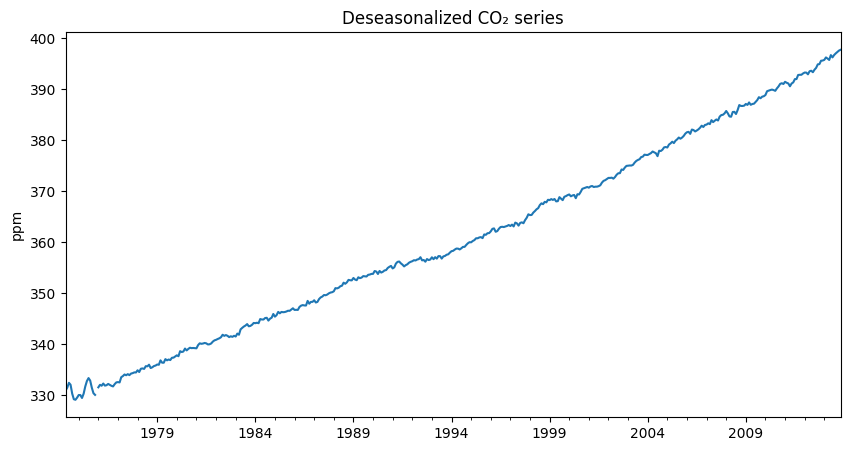

In [63]:
train["seasonal_stripped"].plot(figsize=(10,5), title="Deseasonalized CO₂ series", ylabel="ppm")


Does it look stationary yet? Discuss with your buddy for the day why or why not.

Our next task is to take this __deseasonalized__ time series and to make it stationary. Try using `.diff()` and see how it looks. Then try diffing one more time to see any changes. 

In [64]:
# Première différenciation
train["diff_1"] = train["seasonal_stripped"].diff()

/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/787142732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["diff_1"] = train["seasonal_stripped"].diff()


In [65]:
# Seconde différenciation (au cas où la première ne suffit pas)
train["diff_2"] = train["diff_1"].diff()

/var/folders/nc/tdzq32bj1_jcbgqywymx03k80000gn/T/ipykernel_64583/2647720269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["diff_2"] = train["diff_1"].diff()


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

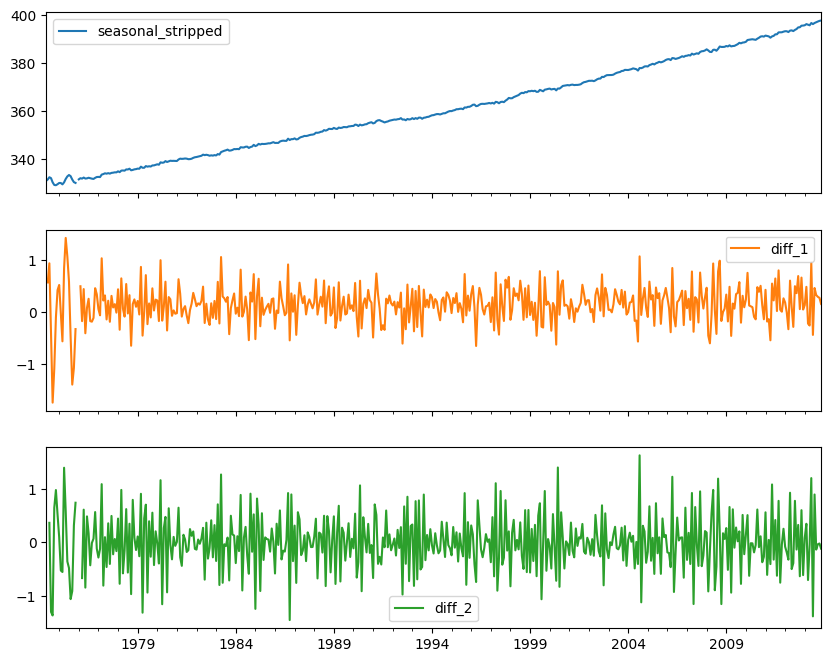

In [66]:
# Visualiser
train[["seasonal_stripped", "diff_1", "diff_2"]].plot(subplots=True, figsize=(10,8))


Both should look quite stationary visually, use the `adfuller` (Augmented Dicky-Fuller) test from the lecture to verify that each one is. 

N.B. When you `diff` you create null values in your DataFrame, you'll need to drop these to perform an ADF test.

In [67]:
from statsmodels.tsa.stattools import adfuller

# Drop NaN avant le test
diff_1 = train["diff_1"].dropna()
diff_2 = train["diff_2"].dropna()

# Test ADF pour diff_1
result1 = adfuller(diff_1)
print("ADF Statistic (1st diff):", result1[0])
print("p-value:", result1[1])

# Test ADF pour diff_2
result2 = adfuller(diff_2)
print("\nADF Statistic (2nd diff):", result2[0])
print("p-value:", result2[1])


ADF Statistic (1st diff): -16.764703202886214
p-value: 1.301532911063686e-29

ADF Statistic (2nd diff): -13.716674192073798
p-value: 1.2092414732364796e-25


1974-06-30    0.563896
1974-07-31    0.932326
1974-08-31   -0.372405
1974-09-30   -1.745106
1974-10-31   -1.093939
                ...   
2013-07-31    0.457315
2013-08-31    0.322936
2013-09-30    0.288054
2013-10-31    0.268194
2013-11-30    0.151354
Name: diff_1, Length: 472, dtype: float64

In [ ]:
# YOUR CODE HERE

Both seem to be reasonably stationary, and it looks like there's no need to overdifference (though we can always try building a twice-diffed time series later). Let's go ahead and plot our `acf` and `pacf` plots (be sure to drop any `null` values - those will break your ACF and PACF calculators) 😔

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [75]:
diff1

1974-06-30    0.563896
1974-07-31    0.932326
1974-08-31   -0.372405
1974-09-30   -1.745106
1974-10-31   -1.093939
                ...   
2013-07-31    0.457315
2013-08-31    0.322936
2013-09-30    0.288054
2013-10-31    0.268194
2013-11-30    0.151354
Name: diff_1, Length: 472, dtype: float64

Taille série: 472
Variance: 0.12880541887585645


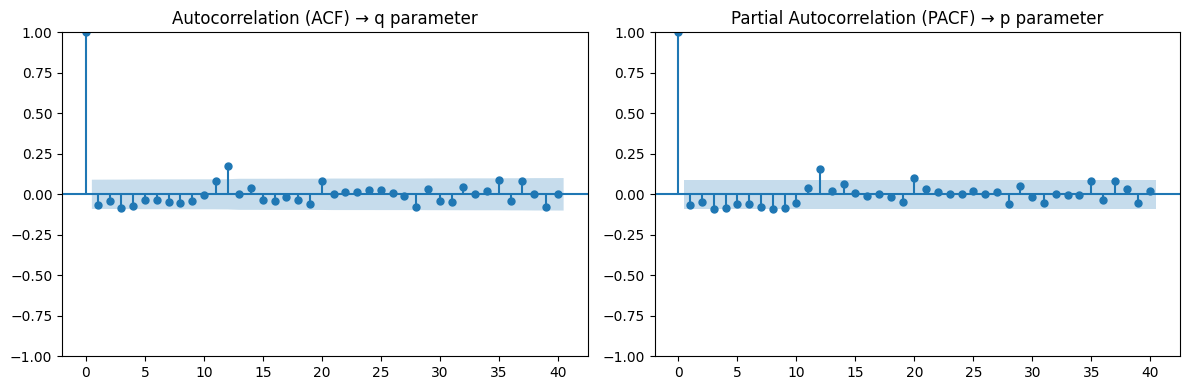

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# On nettoie la série (drop NaN + copie propre)
diff1 = train["diff_1"].dropna().copy()

# Vérification rapide
print("Taille série:", len(diff1))
print("Variance:", diff1.var())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(diff1, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF) → q parameter")

plot_pacf(diff1, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF) → p parameter")

plt.tight_layout()
plt.show()


Take the time to really talk through what these plots actually mean with your buddy. Which one corresponds to your `p` parameter and which corresponds to your `q` parameter?

Now build a simple ARIMA model with the appropriate order values for your `p` `d` and `q` values. Investigate its model summary.

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# On entraîne le modèle ARIMA(1,1,1)
model = ARIMA(train["seasonal_stripped"], order=(1, 1, 1))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -191.184
Date:                Mon, 10 Nov 2025   AIC                            388.368
Time:                        16:25:41   BIC                            400.852
Sample:                    05-31-1974   HQIC                           393.278
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   2667.767      0.000       0.999       1.001
ma.L1         -0.9959      0.014    -73.309      0.000      -1.023      -0.969
sigma2         0.1304      0.006     21.269      0.0

What do you note about the summary? What are the most important features here?

It looks like we can trust our coefficients and we have an AIC of ~223. But was it the best model? Trying using the `auto_arima` function to grid search different models and see which has the best AIC

In [85]:
from pmdarima import auto_arima

y = monthly.dropna()

auto_model = auto_arima(
    y,
    seasonal=False,  # ou True selon consigne plus bas
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=1,
    trace=True,
    stepwise=True,
    information_criterion='aic'
)

print(auto_model.summary())
print("Best model order:", auto_model.order)
print("Best AIC:", auto_model.aic())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1973.049, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1580.938, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1624.032, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1978.612, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1425.538, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1370.210, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1222.407, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1221.246, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1504.223, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1222.161, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1452.884, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1223.220, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1316.060, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.262 seconds
                      

In [ ]:
# YOUR CODE HERE

In [82]:
best_AIC=359.20161239323716

Save your best AIC score to `best_AIC`

In [ ]:
# YOUR CODE HERE

In [83]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/simonhingant/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/simonhingant/code/simsam56/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score FAILED                          [100%]

=================================== FAILURES ===================================
___________________________ TestScore.test_AIC_score ___________________________

self = <test_score.TestScore testMethod=test_AIC_score>

    def test_AIC_score(self):
>       self.assertTrue(self.result.aic_score < 216.0)
E       AssertionError: False is not true

test_score.py:5: AssertionError
=========================== short test summary info ============================
FAILED test_score.py::TestScore::test_AIC_score - AssertionError:

Often times, it can be hard to predict which model with fit best on our data so it is usually a good idea to grid-search and compare your models' AIC scores 🧐 Here, it looks like a __(0,1,1)__ model gets a better AIC score (so the MA components of our original model probably weren't improving our model likelihood that much!)

### Making predictions (get ready for some Pandas work!)

Now that we have our best model, we'd like to generate some predictions and - crucially - some confidence intervals. Use your model to predict for the length of your test set and ensure that you also return those intervals (use `return_conf_int = True`). Create a `preds_df` DataFrame with columns for `preds`, `upper` and `lower` bounds.

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())

Now plot them, out and see how they look compared alongside your `train` data

In [ ]:
# YOUR CODE HERE

Something looks a bit wrong doesn't it? We're looking at three straight lines coming out of something that clearly had seasonality. To account for this, we need to re-incorporate the seasonality component that we extracted earlier!

Create a `month` column in your `preds_df` DataFrame and populate it with the month component of the index. 

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

Now we can take our `seasonal_one_year` DataFrame that we made earlier and simply merge it onto our `preds_df`!

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
preds_df

Now you can create your `full_preds`, `upper_conf` and `lower_conf` (create them as new columns in the `preds_df` DataFrame) by multiplying out your `preds`, `upper` __and__ `lower` columns with the seasonal component that we now have in our `preds_df` DataFrame.

In [ ]:
# YOUR CODE HERE

Finally, to make plotting easier for us, set the index of your `preds_df` to be the same as the index of your `test` DataFrame (since they have the same length this should be quite easy for us!)

In [ ]:
# YOUR CODE HERE

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())

Now plot everything out - the end of your train (e.g. the last 100 values, your full predictions, upper and lower confidence bounds and the true values from your `preds_df` DataFrame __and__ your baseline!

In [ ]:
# YOUR CODE HERE

Our predictions look pretty good! We can see that the true values are slightly higher than what we predicted but remains well within the bounds of our confidence intervals for a full 10 years out from when we started making our predictions.

Why did our values dip below the true values? Run the cell below to decompose the test data and take a look at the trend component 👀


In [ ]:
seasonal_decompose(test["CO2 molfrac (ppm)"]).plot();

It looks like in 2016-2018 there was a __slight rise__ in all of our values before the regular (slightly shallower) trend took over again. This is a great example of something occuring in our test dataset that we simply cannot predict. We don't know why there was a surge in CO2 readings - and we couldn't predict for it.

❗ When we model with Time Series, we __cannot magically predict the future__. What we're trying to do is accurately capture and then extend the patterns of the past. 

- Often times, your raw predictions (without a seasonal component) will look like a fairly boring straight line 🙄 (as our current initial ones did) but this is what we'd expect
- Some of the most value that we get out when doing Time Series analysis lies in being able to __quantify__ our trends, seasonal components and our confidence intervals so we can make well-informed decisions ✅

Finally, let's quickly quantify how much better our model was than our baseline. Calculate the mean absolute error between your `preds` (with their seasonal component) and the true values. See if your `model_mae` is lower than the original `baseline_mae`. 

In [ ]:
model_mae = (test["CO2 molfrac (ppm)"] - preds_df["full_preds"]).mean()

In [ ]:
# YOUR CODE HERE

Our final MAE should be __much__ better than our original baseline. Great work 🥳 In another challenge, we'll explore how we can use Facebook Prophet to quickly make powerful predictions without the need for decomposition.